# Computer Assignment 4: CNN Segmentation
## Alaqian Zafar - aaz7118

## Table of Contents
- <a href='#p1a'>Part (a)</a>
- <a href='#p1b'>Part (b)</a>
- <a href='#p1c'>Part (c)</a>
- <a href='#p1d'>Part (d)</a>
- <a href='#p2a'>Part (e)</a>
- <a href='#p2b'>Part (f)</a>
- <a href='#p2c'>Part (g)</a>

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

%matplotlib inline

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/ECE-GY 6123 Image and Video Processing/Computer Assignments/CA04/archive'
except:
    path = 'archive'

<a id='p1a'></a>
##### (a) Cut the FudanPed dataset into an 80-10-10 train-val-test split.

[Table of Contents](#Table-of-Contents)

In [3]:
image_paths = sorted([os.path.join(path, "PNGImages", image) for image in os.listdir(os.path.join(path, "PNGImages"))])
mask_paths = sorted([os.path.join(path, "PedMasks", mask) for mask in os.listdir(os.path.join(path, "PedMasks"))])

indices = list(range(len(image_paths)))
train_indices = random.sample(indices, k=int(len(indices)*0.8))
val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))
test_indices = list(set(indices)-set(train_indices)-set(val_indices))

train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]
test_image_paths = [image_paths[i] for i in test_indices]
test_mask_paths = [mask_paths[i] for i in test_indices]

class PennFudanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)
        # binarize the mask by setting all values greater-than or equal-to 1 to 1.
        mask = np.clip(mask, 0, 1)*255
        merged_image = np.concatenate((image, mask[:, :, None]), axis=2)
        merged_image = transforms.ToTensor()(merged_image)
        if self.transform:
            merged_image = self.transform(merged_image)
        image = merged_image[:3, :, :]
        mask = merged_image[3, :, :]
        #image = transforms.ToTensor()(image)
        #mask = transforms.ToTensor()(mask)
        return image, mask

<a id='p1b'></a>
##### (b) Apply data augmentation to your dataset during training and show an example of your data augmentation in your report.

[Table of Contents](#Table-of-Contents)

Text(0.5, 1.0, 'Augmented Mask')

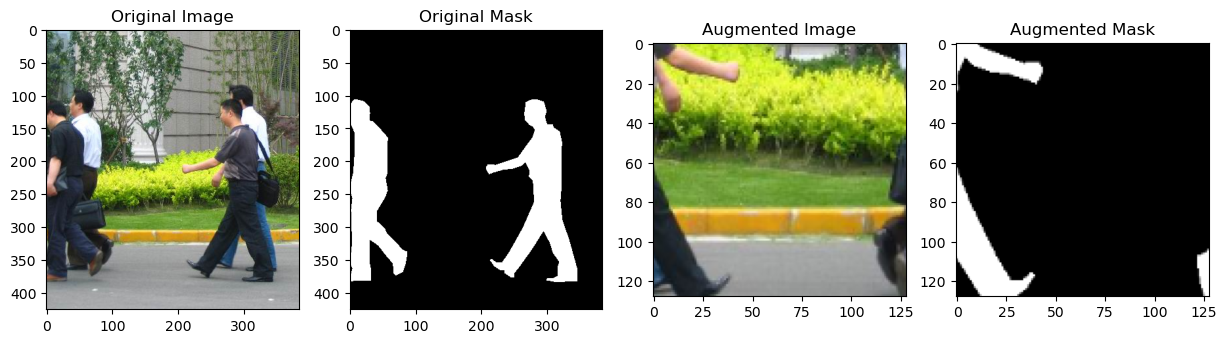

In [4]:
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(128, antialias=None)
    ])

# Plot a subplot of the original and the augmented image and mask
train_dataset = PennFudanDataset(train_image_paths, train_mask_paths)
image, mask = train_dataset[0]
fig, ax = plt.subplots(1, 4, figsize=(15, 7.5))
ax[0].imshow(image.permute(1, 2, 0))
ax[0].set_title("Original Image")
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Original Mask")

augmented_train_dataset = PennFudanDataset(train_image_paths, train_mask_paths, transform=augmentation)
image, mask = augmented_train_dataset[0]
ax[2].imshow(image.permute(1, 2, 0))
ax[2].set_title("Augmented Image")
ax[3].imshow(mask, cmap="gray")
ax[3].set_title("Augmented Mask")

<a id='p1c'></a>
##### (c) Implement and train a CNN for binary segmentation on your train split. Describe your network architecture, loss function, and any training hyper-parameters. You may implement any architecture you'd like, **but the implementation must be your own code.**

[Table of Contents](#Table-of-Contents)

In [5]:
# (c) Implement and train a CNN for binary segmentation on your train split. Describe your network architecture2, loss function, and any training hyper-parameters. 
# You may implement any architecture you'd like, **but the implementation must be your own code.**
# It is strongly suggested that you implement the UNet architecture which is described in the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597).
# You can implement downsampling via 2 x 2 Max-pooling and upsampling by bilinear upsampling.

class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.Conv_BN_ReLU1 = self._Conv_BN_ReLU(3, 16)
        self.Downsample1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU2 = self._Conv_BN_ReLU(16, 32)
        self.Downsample2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU3 = self._Conv_BN_ReLU(32, 32)
        self.Upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU4 = self._Conv_BN_ReLU(64, 16)
        self.Upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU5 = self._Conv_BN_ReLU(32, 16)
        self.Conv6 = nn.Conv2d(16, 1, kernel_size=1)

    def _Conv_BN_ReLU(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x1 = self.Conv_BN_ReLU1(x) # 3x128x128 -> 16x128x128
        x2 = self.Downsample1(x1) # 16x128x128 -> 16x64x64
        x3 = self.Conv_BN_ReLU2(x2) # 16x64x64 -> 32x64x64
        x4 = self.Downsample2(x3) # 32x64x64 -> 32x32x32
        x5 = self.Conv_BN_ReLU3(x4) # 32x32x32 -> 32x32x32
        x6 = self.Upsample1(x5) # 32x32x32 -> 32x64x64
        x7 = torch.cat((x6, x3), dim=1) # 32x64x64 + 32x64x64 -> 64x64x64
        x8 = self.Conv_BN_ReLU4(x7) # 64x64x64 -> 16x64x64
        x9 = self.Upsample2(x8) # 16x64x64 -> 16x128x128
        x10 = torch.cat((x9, x1), dim=1) # 16x128x128 + 16x128x128 -> 32x128x128
        x11 = self.Conv_BN_ReLU5(x10) # 32x128x128 -> 16x128x128
        x12 = self.Conv6(x11) # 16x128x128 -> 1x128x128
        x13 = torch.sigmoid(x12) # 1x128x128 -> 1x128x128
        return x13


![Architecture](UNET.png)

<a id='p1d'></a>
##### (d) Report training loss, validation loss, and validation DICE curves. Comment on any overfitting or underfitting observed.

[Table of Contents](#Table-of-Contents)

<a id='p2a'></a>
##### (e) Report the average dice score over your test-set. **You should be able to achieve a score of around 0.7 or better**.

[Table of Contents](#Table-of-Contents)

<a id='p2b'></a>
##### (f) Show at least 3 example segmentations (i.e. show the RGB image, mask, and RGB image X mask for 3 samples) from your training data and 3 from your testing data. Comment on the generalization capabilities of your trained network.

[Table of Contents](#Table-of-Contents)

<a id='p2c'></a>
##### (g) Show at least 1 example segmentation on an input image **<ins>not</ins> from the FudanPed dataset**. Again, comment on the generalization capabilities of your network with respect to this "out-of-distribution" image.

[Table of Contents](#Table-of-Contents)

In [6]:
# Create a README.md from this notebook
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to html --template lab

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to html
[NbConvertApp] Writing 1040093 bytes to aaz7118-CA04.html
